# Dataset

* 10,882 protein chains from high-res (< 2.5Å) structures from PDB (Nov 2018)
* length ≥ 40 amino acids
* cleaned at 30% sequence identity
* no chain breaks (missing residues)

In [1]:
import json, gzip

with gzip.open('../data/phipsi.json.gz', 'rb') as f:
    dataset = json.load(f)

```dataset``` is a Python dictionary with just one entry: the key ```'phipsi10882'``` is pointing to a list of 10,882 elements. Each element describes one protein chain and is represented by a dictionary with three entries:
* ```'sequence'``` - 1-letter amino acid sequence
* ```'phi'``` - list of &phi; angles
* ```'psi'``` - list of &psi; angles

In [2]:
print("Number of proteins in the set: {}".format(len(dataset['phipsi10882'])))
print("Keys of the first entry (and all others): {}".format(dataset['phipsi10882'][0].keys()))

Number of proteins in the set: 10882
Keys of the first entry (and all others): dict_keys(['sequence', 'phi', 'psi'])


In [3]:
# reduse dataset to a list for simpler access
dataset = dataset['phipsi10882']

## Cleaning 
* Convert amino acid sequences to numbers (0,..,19) and store them in ```numpy``` arrays
* Convert &phi;,&psi; lists to ```numpy``` arrays
* Get rid of first and last residues (due to undefined dihedrals)

In [4]:
import numpy as np

aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

for item in dataset:
    n = len(item['sequence'])
    item['sequence'] = np.array([aa2idx[aa] for aa in item['sequence'][1:n-1]], dtype=np.int8)
    item['phi'] = np.array(item['phi'], dtype=np.float32)[1:n-1]
    item['psi'] = np.array(item['psi'], dtype=np.float32)[1:n-1]

print("Total number of residues: {}".format(np.sum([len(item['sequence']) for item in dataset])))

Total number of residues: 2385006


## Visualizations

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Merge &phi; and &psi; angles from all protein into two corresponding arrays. Limit to 1/100 of the dataset to speed things up. 

In [6]:
phi = np.hstack([item['phi'] for item in dataset])[::100]
psi = np.hstack([item['psi'] for item in dataset])[::100]

Estimate local density of (&phi;,&psi;) pairs to have nice pictures

In [7]:
from scipy.stats import gaussian_kde

rama = np.vstack([phi.T,psi.T])
density = gaussian_kde(rama)(rama)

Show one Ramachandran plot for all amino acid types. Color-code dots according to their local density

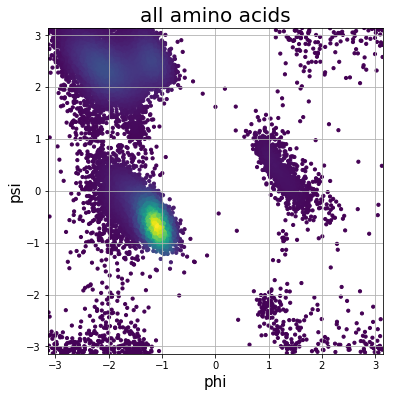

In [8]:
plt.figure(figsize=(6,6))
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.xlabel('phi', fontsize=15)
plt.ylabel('psi', fontsize=15)
plt.grid()
plt.rc('axes', axisbelow=True)
plt.title('all amino acids', fontsize=20)
plt.scatter(phi, psi, c=density, s=10)
plt.show()

Rama maps for each amino acid type separately

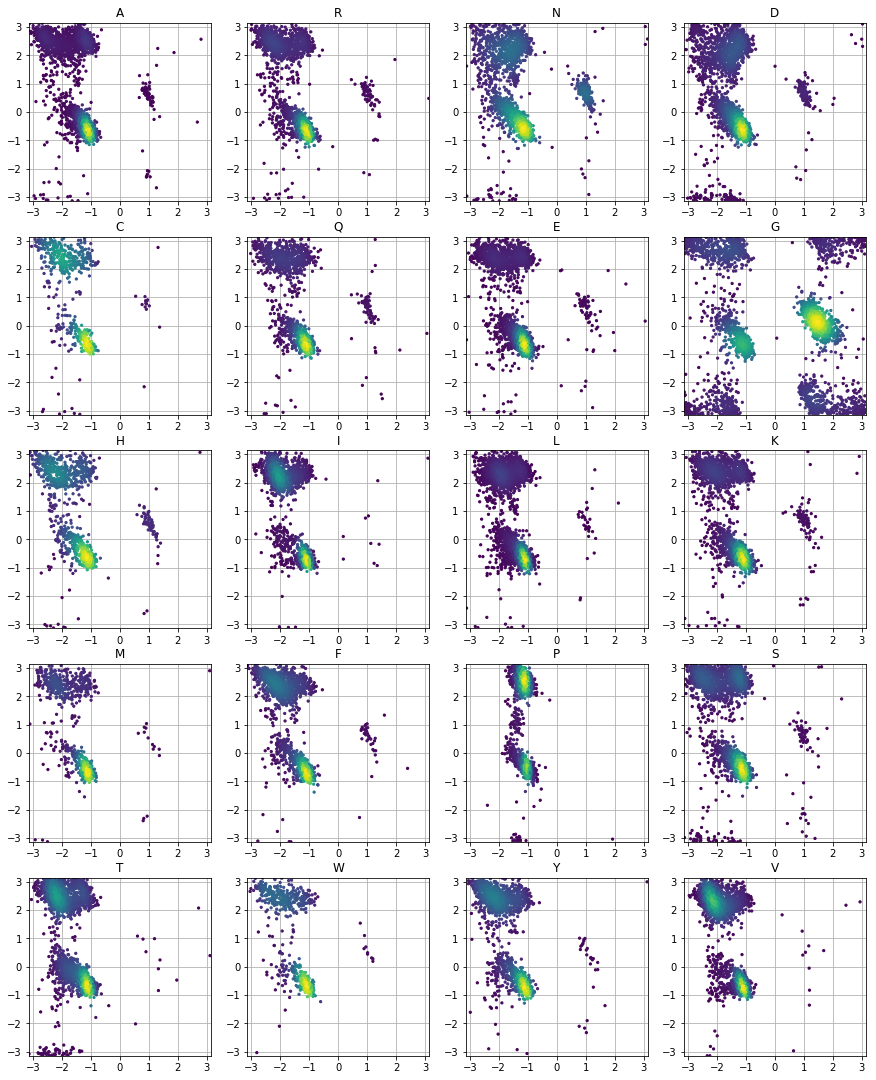

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=4)
fig.set_size_inches(15, 19)

# set style
for key,val in aa2idx.items():
    row = val//4
    col = val%4
    ax[row,col].set_xlim([-np.pi,np.pi])
    ax[row,col].set_ylim([-np.pi,np.pi])
    ax[row,col].set_xticks((-3,-2,-1,0,1,2,3))
    ax[row,col].set_yticks((-3,-2,-1,0,1,2,3))
    ax[row,col].grid()
    ax[row,col].set_title(key)

# select 1/50 of the dataset
aa = np.hstack([item['sequence'] for item in dataset])[::50]
phi = np.hstack([item['phi'] for item in dataset])[::50]
psi = np.hstack([item['psi'] for item in dataset])[::50]

# loop over all amino acid types
for key,val in aa2idx.items():
    phi_ = phi[np.where(aa == val)]
    psi_ = psi[np.where(aa == val)]
    rama = np.vstack([phi_.T,psi_.T])
    density = gaussian_kde(rama)(rama)
    row = val//4
    col = val%4
    ax[row,col].scatter(phi_, psi_, c=density, s=5)